In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import math
import torchvision.models as models
from PIL import Image
from deepfool.deepfool import deepfool, local_deepfool, deepfool_specific
import os
import copy


from utils import diff, plot_diff, plot_comparaison, make_examples

from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
import random

NUM_CLASSES = 100
MAX_ITER = 100
OVERSHOOT = 0.02
TARGET_CLASS = 413

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
# region_mask = np.zeros((224, 224), dtype=np.int32)
# region_mask[50:150, 50:150] = 1


# plt.imshow((region_mask))
# plt.imshow(region_mask, cmap="gray")
# plt.show()

# region_mask = None

In [4]:
try:
    train_set = torchvision.datasets.Imagenette(
        root="./dataset", split="train", download=True
    )
    val_set = torchvision.datasets.Imagenette(
        root="./dataset", split="val", download=True
    )
except:
    print("Error while downloading the dataset")

Error while downloading the dataset


Number of training samples: 9469
Classes in training set: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Number of validation samples: 3925
Classes in validation set: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


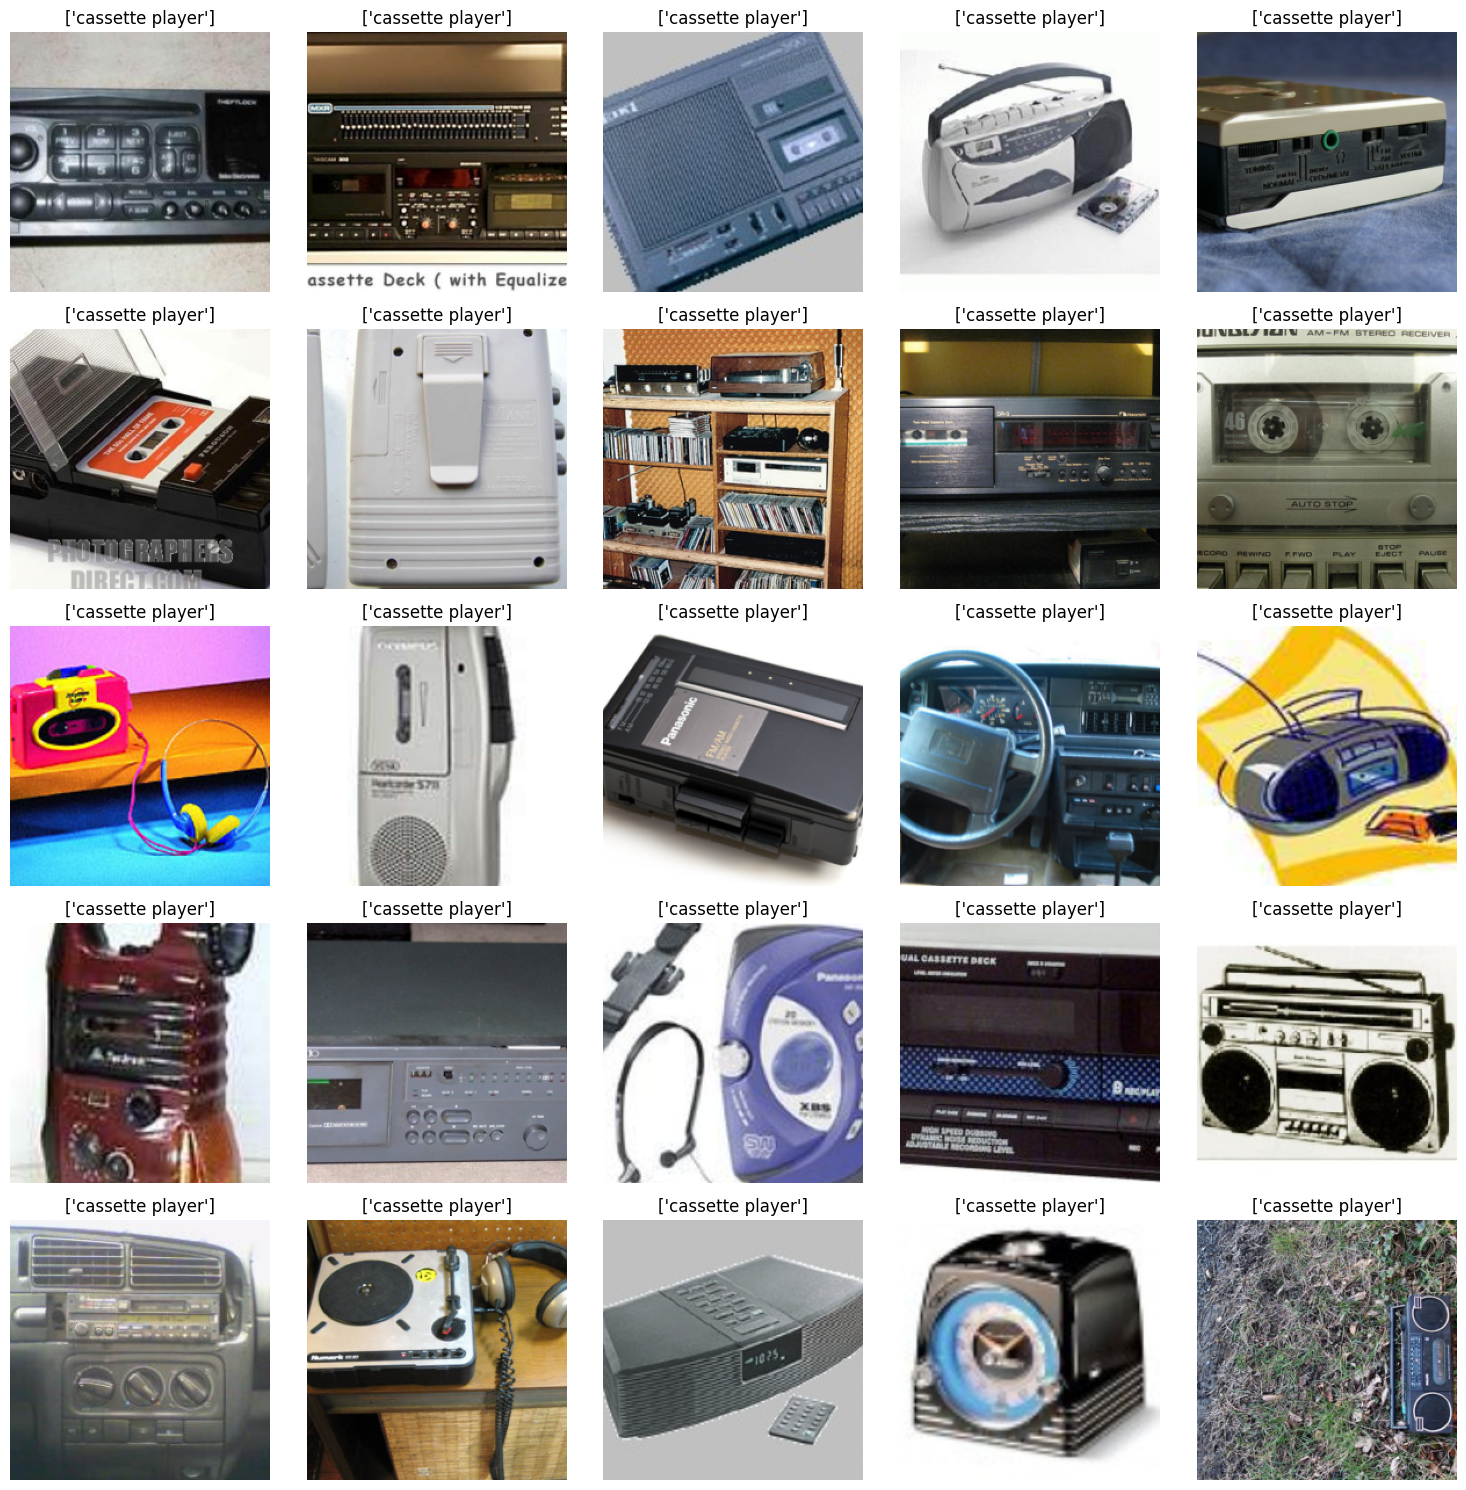

In [5]:
transform = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]
)

orig_train_set = datasets.ImageFolder(
    "./dataset/imagenette2/train", transform=transform
)

orig_val_set = datasets.ImageFolder("./dataset/imagenette2/val", transform=transform)


transform_net = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = datasets.ImageFolder("./dataset/imagenette2/train", transform=transform_net)

val_set = datasets.ImageFolder("./dataset/imagenette2/val", transform=transform_net)
# Create a smaller validation set
sub_val_set, _ = random_split(val_set, [500, len(val_set) - 500])

LABELS = {
    line.split(" ")[0]: " ".join(line.split(" ")[1:])
    for line in open(os.path.join("data/demo_deepfool/synset_words.txt"), "r")
    .read()
    .split("\n")
}


def id2label(id):
    return LABELS[id].split(",")


# Explore the train_set
print(f"Number of training samples: {len(train_set)}")
print(f"Classes in training set: {train_set.classes}")

# Explore the val_set
print(f"Number of validation samples: {len(val_set)}")
print(f"Classes in validation set: {val_set.classes}")

# Display 5 images of 5 classes each class in one column
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    img, label = orig_val_set[i + 1000]
    # print(img.shape)
    ax = axes[i // 5, i % 5]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(id2label(val_set.classes[label]))
plt.tight_layout()
plt.show()


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        output = self.resnet(x)
        return output


def load_model_parameters(model, path):
    if os.path.isfile(path):
        model.load_state_dict(torch.load(path))
        print("Model parameters loaded successfully.")
    else:
        print("Model parameter file not found.")


# Example usage
model = Net()
load_model_parameters(model, "resnet34_imagenette.pth")

/home/mkherraz001/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mkherraz001/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model parameters loaded successfully.


/tmp/ipykernel_548932/3215031810.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


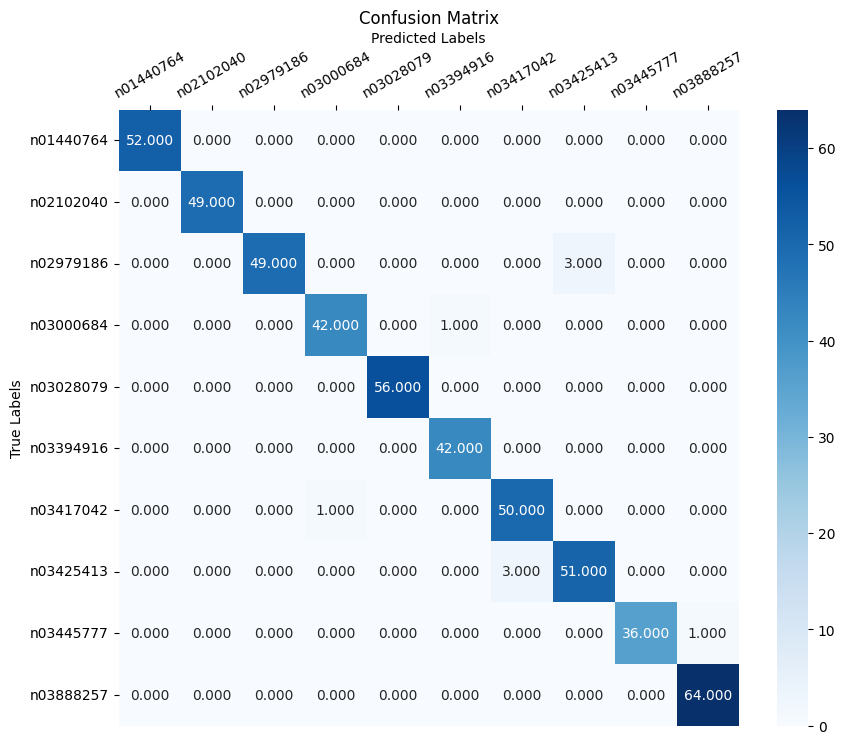

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Function to evaluate the model and get predictions
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


# Create DataLoader for validation set
val_loader = DataLoader(sub_val_set, batch_size=128, shuffle=False)

# Get true labels and predictions
true_labels, predictions = evaluate_model(model, val_loader)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
# cm = confusion_matrix(true_labels, predictions, normalize='true')

# Plot confusion matrix with predicted labels on top
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=val_set.classes,
    yticklabels=val_set.classes,
)
ax.set(xlabel="", ylabel="")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

In [8]:
from utils import perturb_set
from deepfool.deepfool import deepfool, local_deepfool, deepfool_specific

perturbed_val_set = perturb_set(local_deepfool, sub_val_set, model)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def clip_tensor(A, minv, maxv):
    return torch.clamp(A, minv, maxv)


clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0, 0, 0], std=[1 / s for s in std]
        ),
        transforms.Normalize(mean=[-m for m in mean], std=[1, 1, 1]),
        transforms.Lambda(clip),
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


Perturbing images: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


True label: 9
Predicted label: 9
Perturbed label: 0


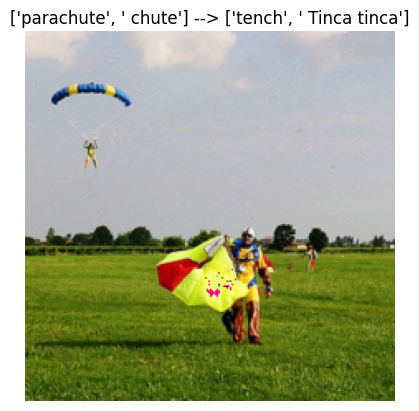

True label: 6
Predicted label: 6
Perturbed label: 3


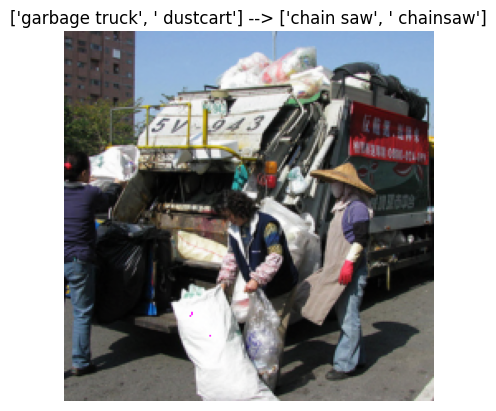

True label: 2
Predicted label: 2
Perturbed label: 7


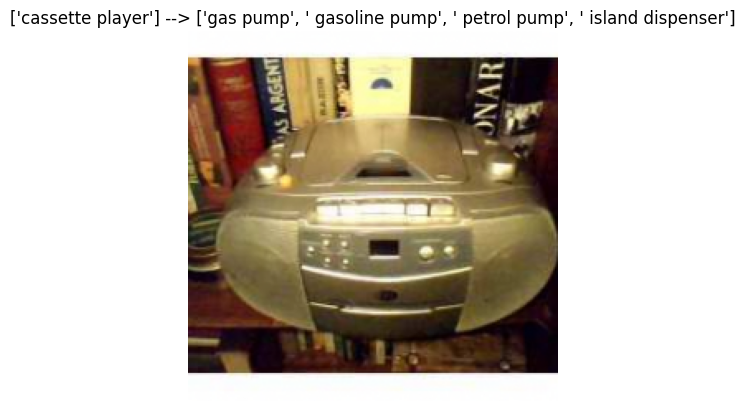

True label: 7
Predicted label: 7
Perturbed label: 4


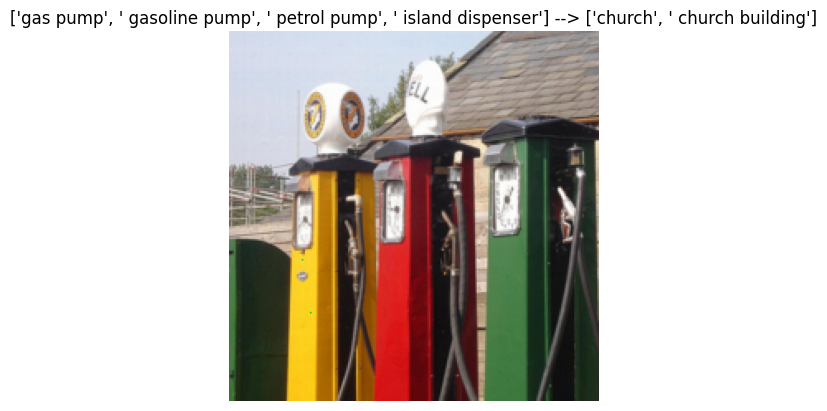

True label: 2
Predicted label: 2
Perturbed label: 5


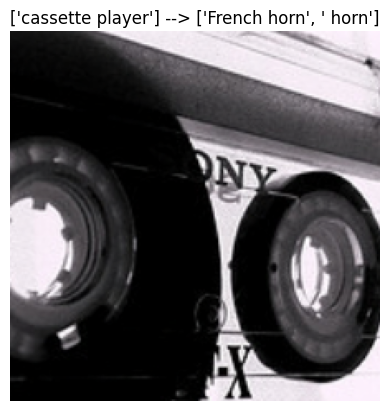

In [9]:
# Display 5 perturbed images
for i, (img, label) in enumerate(perturbed_val_set):
    if i == 5:
        break
    transformed_img = tf(img)
    plt.imshow(transformed_img.permute(1, 2, 0).cpu().numpy())
    print(f"True label: {label[0].item()}")
    print(f"Predicted label: {label[1].item()}")
    print(f"Perturbed label: {label[2].item()}")
    plt.title(f"{id2label(val_set.classes[label[1].item()])} --> {id2label(val_set.classes[label[2].item()])}")
    plt.axis("off")
    plt.show()


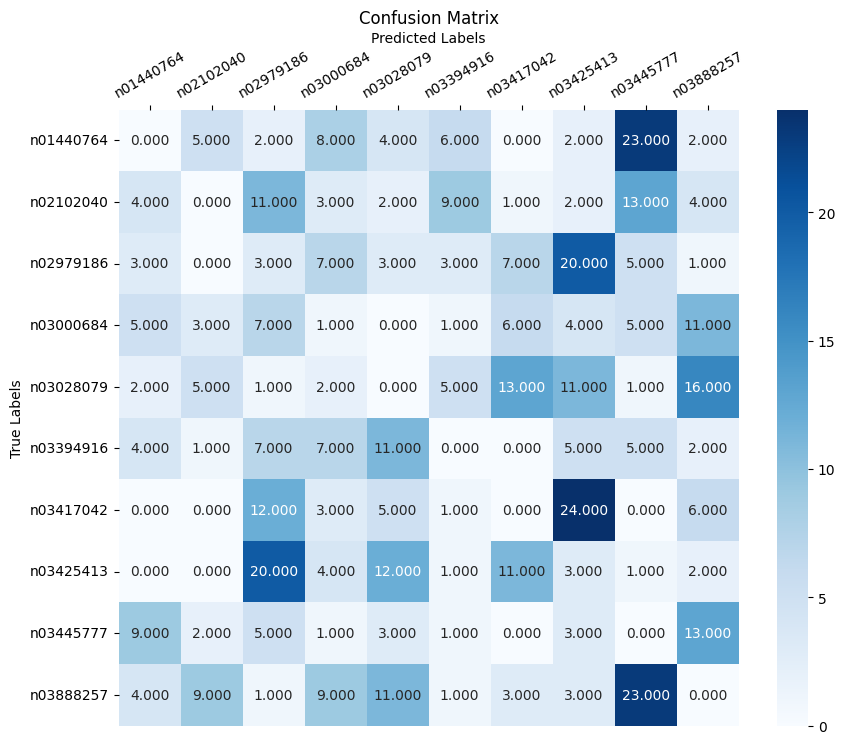

In [10]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, [label[2].item() for _, label in perturbed_val_set])
# cm = confusion_matrix(true_labels, predictions, normalize='true')

# Plot confusion matrix with predicted labels on top
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=val_set.classes,
    yticklabels=val_set.classes,
)
ax.set(xlabel="", ylabel="")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()